# Day cloud phase RGB (RGB example using reprojected VIS and IR channels)
This jupyter notebook shows how to make a sub-region plot of Day cloud phase RGB composition. This is an example of RGB composition using reprojected VIS and IR channels of GOES-16. \
**Warning: if your RAM is less than 8GB it is recommended to work with a small domain.**

Import the GOES package.

In [1]:
import GOES

Set path and name of file that will be read.

In [2]:
path = '/home/joao/Downloads/GOES-16/ABI/'
C02_file = 'OR_ABI-L2-CMIPF-M6C02_G16_s20210331700146_e20210331709454_c20210331709523.nc'
C05_file = 'OR_ABI-L2-CMIPF-M6C05_G16_s20210331700146_e20210331709454_c20210331709532.nc'
C13_file = 'OR_ABI-L2-CMIPF-M6C13_G16_s20210331700146_e20210331709465_c20210331709558.nc'

Reads the file.

In [3]:
C02_ds = GOES.open_dataset(path+C02_file)
C05_ds = GOES.open_dataset(path+C05_file)
C13_ds = GOES.open_dataset(path+C13_file)

Set the map domain.

In [4]:
domain = [-90.0,-30.0,-60.0,15.0]

Creates a grid map with cylindrical equidistant projection and 1.0 km of spatial resolution.

In [5]:
LonCenCyl, LatCenCyl = GOES.create_gridmap(domain, PixResol=1.0)

Calculates the coordinates of corners of pixels.

In [6]:
LonCorCyl, LatCorCyl = GOES.calculate_corners(LonCenCyl, LatCenCyl)

Calculates the parameters for reprojection. For this we need install the pyproj and pyresample packages. Try with pip install pyproj and pip install pyresample.

In [7]:
import pyproj as pyproj
Prj = pyproj.Proj('+proj=eqc +lat_ts=0 +lat_0=0 +lon_0=0 +x_0=0 +y_0=0 +a=6378.137 +b=6378.137 +units=km')
AreaID = 'cyl'
AreaName = 'cyl'
ProjID = 'cyl'
Proj4Args = '+proj=eqc +lat_ts=0 +lat_0=0 +lon_0=0 +x_0=0 +y_0=0 +a=6378.137 +b=6378.137 +units=km'

ny, nx = LonCenCyl.data.shape
SW = Prj(LonCenCyl.data.min(), LatCenCyl.data.min())
NE = Prj(LonCenCyl.data.max(), LatCenCyl.data.max())
area_extent = [SW[0], SW[1], NE[0], NE[1]]

from pyresample import utils
AreaDef = utils.get_area_def(AreaID, AreaName, ProjID, Proj4Args, nx, ny, area_extent)

Gets C02 image with the coordinates of center of their pixels.

In [8]:
C02, LonCen, LatCen = C02_ds.image('CMI', lonlat='center', domain=domain)

Reprojects C02 image.

In [9]:
import numpy as np
from pyresample.geometry import SwathDefinition
from pyresample.kd_tree import resample_nearest

SwathDef = SwathDefinition(lons=LonCen.data, lats=LatCen.data)
C02Cyl = resample_nearest(SwathDef, C02.data, AreaDef, radius_of_influence=6000,
                          fill_value=np.nan, epsilon=3, reduce_data=True)

Deletes unnecessary data.

In [10]:
del C02, LonCen, LatCen

Gets C05 image with the coordinates of center of their pixels.

In [11]:
C05, LonCen, LatCen = C05_ds.image('CMI', lonlat='center', domain=domain)

Reprojects C05 image.

In [12]:
SwathDef = SwathDefinition(lons=LonCen.data, lats=LatCen.data)
C05Cyl = resample_nearest(SwathDef, C05.data, AreaDef, radius_of_influence=6000,
                          fill_value=np.nan, epsilon=3, reduce_data=True)

Deletes unnecessary data.

In [13]:
del C05, LonCen, LatCen

Gets C13 image with the coordinates of center of their pixels.

In [14]:
C13, LonCen, LatCen = C13_ds.image('CMI', lonlat='center', domain=domain)

Reprojects C13 image.

In [15]:
SwathDef = SwathDefinition(lons=LonCen.data, lats=LatCen.data)
C13Cyl = resample_nearest(SwathDef, C13.data, AreaDef, radius_of_influence=6000,
                          fill_value=np.nan, epsilon=3, reduce_data=True)

Gets information about data.

In [16]:
sat = C13_ds.attribute('platform_ID')
time = C13_ds.variable('time_bounds').data[0]

Deletes unnecessary data.

In [17]:
del C13, LonCen, LatCen

Defines the name of product.

In [18]:
product = 'Day snow-fog RGB'

Calculates the cosine of zenith angle.

In [19]:
cosz = GOES.cosine_of_solar_zenith_angle(LonCenCyl.data, LatCenCyl.data, time)

Deletes unnecessary data.

In [20]:
del LonCenCyl, LatCenCyl

Makes the RGB composition.

In [21]:
# converts reflectance factor of channel 01, 02 and 03 to reflectance and save them as R, G and B
R = C13Cyl - 273.15
G = C02Cyl/cosz.data
B = C05Cyl/cosz.data

# set limits of channels
Rmin, Rmax = -53.5, 7.5
Gmin, Gmax = 0.0, 0.78
Bmin, Bmax = 0.1, 0.59
R = np.clip(R, Rmin, Rmax)
G = np.clip(G, Gmin, Gmax)
B = np.clip(B, Bmin, Bmax)

# normalize channels
R = (R-Rmin)/(Rmax-Rmin)
G = (G-Gmin)/(Gmax-Gmin)
B = (B-Bmin)/(Bmax-Bmin)

# perfoms a gamma correction
gamma = 1.0
R = np.power(R, 1/gamma)
G = np.power(G, 1/gamma)
B = np.power(B, 1/gamma)

# invert the channel
R = 1.0 - R

# stack channels
RGB = np.dstack((R, G, B)).astype(np.float16)

# reshape RGB to 1-D array
RGB = RGB.reshape((RGB.shape[0]*RGB.shape[1],RGB.shape[2]))

# ensures RGB data is between 0 and 1
RGB = np.clip(RGB, 0.0, 1.0, dtype=RGB.dtype)

# creates a simple array to make the plot with pcolormesh
mask = np.where(np.isnan(C13Cyl)==True, np.nan, 1).astype(np.float16)

Deletes unnecessary data.

In [22]:
del C02Cyl, C05Cyl, C13Cyl, cosz, R, G, B

Creates plot.

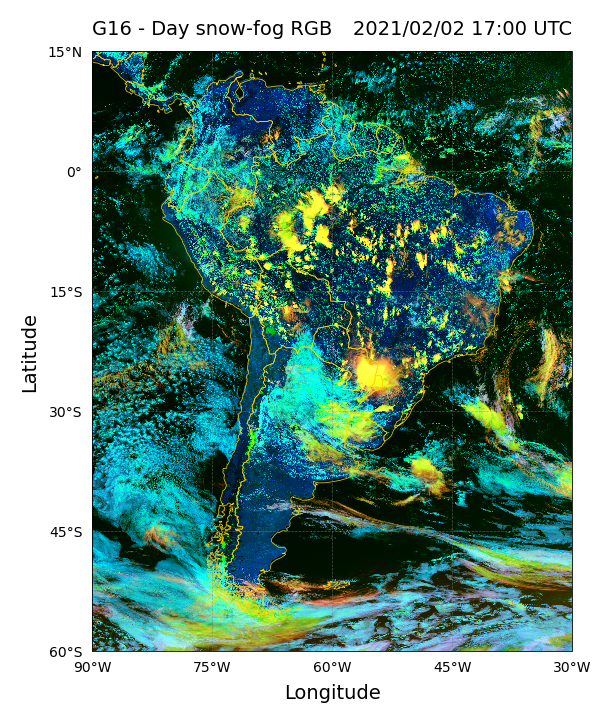

In [23]:
# import packages
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter

# calculates the central longitude of the plot
lon_cen = 360.0+(domain[0]+domain[1])/2.0

# creates the figure
fig = plt.figure('map', figsize=(4,4), dpi=200)
ax = fig.add_axes([0.1, 0.16, 0.80, 0.75], projection=ccrs.PlateCarree(lon_cen))
ax.outline_patch.set_linewidth(0.3)

# add the geographic boundaries
l = NaturalEarthFeature(category='cultural', name='admin_0_countries', scale='50m', facecolor='none')
ax.add_feature(l, edgecolor='gold', linewidth=0.25)

# plot the data
img = ax.pcolormesh(LonCorCyl.data, LatCorCyl.data, mask, transform=ccrs.PlateCarree(), color=RGB)

# set the title
ax.set_title('{} - {}'.format(sat, product), fontsize=7, loc='left')
ax.set_title(time.strftime('%Y/%m/%d %H:%M UTC'), fontsize=7, loc='right')

# Sets X axis characteristics
dx = 15
xticks = np.arange(domain[0], domain[1]+dx, dx)
ax.set_xticks(xticks, crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter(dateline_direction_label=True))
ax.set_xlabel('Longitude', color='black', fontsize=7, labelpad=3.0)

# Sets Y axis characteristics
dy = 15
yticks = np.arange(domain[2], domain[3]+dy, dy)
ax.set_yticks(yticks, crs=ccrs.PlateCarree())
ax.yaxis.set_major_formatter(LatitudeFormatter())
ax.set_ylabel('Latitude', color='black', fontsize=7, labelpad=3.0)

# Sets tick characteristics
ax.tick_params(left=True, right=True, bottom=True, top=True,
               labelleft=True, labelright=False, labelbottom=True, labeltop=False,
               length=0.0, width=0.05, labelsize=5.0, labelcolor='black')

# Sets grid characteristics
ax.gridlines(xlocs=xticks, ylocs=yticks, alpha=0.6, color='gray',
             draw_labels=False, linewidth=0.25, linestyle='--')

# set the map limits
ax.set_extent([domain[0]+360.0, domain[1]+360.0, domain[2], domain[3]], crs=ccrs.PlateCarree())

plt.show()